# NLP practical session 2: the grounded naming game

This notebook presents an implementation of a neuro-symbolic version of the seminal naming game experiment, in which a population of agents converges on a naming convention for referring to entities that they observe in their environment.

The experiment uses image data from the https://www.kaggle.com/datasets/alessiocorrado99/animals10/code .


## 1. Initialisation
### 1.1 Installations

The first time you run this notebook, you might need to install a number of Python modules in your environment:

In [1]:
 # Ensure to upgrade to the latest version of pyfcg
! pip install --upgrade pyfcg

# Machine learning / neural networks
! pip install numpy
! pip install torch
! pip install scikit-learn

# Visualisation
! pip install matplotlib
! pip install alive_progress

# Downloading benchmark data
! pip install kagglehub
! pip install torchvision

### 1.2 Imports

We can now load Python modules and initialise PyFCG:

In [2]:
import os
import random

import alive_progress
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pyfcg as fcg
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset

# force_download=True ensures that you have the latest version of the underlying fcg-go software,
# (you only need to do this once, afterwards you can set force_download to False)
fcg.init(force_download=False)

My device supports cuda, so I used GPU for dealing with neural networks.

In [3]:
# Device for torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Force CPU for compatibility

Ensure that working directory is setup correctly so that relative paths are correctly set.

In [4]:
# print current working directory
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\paolo\Desktop\recognition


### 1.3 Experiment configurations

In [5]:
# Global variables holding default configuration settings #
###########################################################

# Configuration of Experiment
CONFIGURATION = {
    'cxn_positive_reward' : 0.1,
    'cxn_negative_reward' : 0.2,
}

### 1.4 Monitors

In [6]:
from itertools import islice

MONITORS = {}

def notify(monitor, value):
    """ Notify will add 'value' to the 'monitor' key in the global variable MONITORS. """
    if monitor in MONITORS:
        MONITORS[monitor].append(value)
    else:
        MONITORS[monitor] = [value]


def window(seq, n=2):
    """ Returns a sliding window (of width n) over the data from the sequence. """
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result


def make_plot_points(monitors, window_size=300): #These will make curves much cleaner without losing important trends.
    """ Creates a new dictionary with the averages of the sliding windows, using the same keys as the monitors. """
    plot_points = {}
    for key in monitors:
        plot_points[key] = []
        generator = window(monitors[key], n=window_size)
        for w in generator:
            plot_points[key].append(np.mean(w))
    return plot_points

## 2. Set-up of the linguistic phase

### 2.2 Representing Grounded Naming Game Agents

We define our agents as instances of a new `Agent` class that subclasses from PyFCG’s `fcg.Agent` class.
The agents are thereby initialised with an empty grammar and inherit a collection of methods for interacting with instances of the `fcg.Grammar` and `fcg.Construction` classes.

In [7]:
class Agent(fcg.Agent):
    """
    Agent subclasses from fcg.Agent.
    """

    def __init__(self, configuration):
        """Initialisation of agents upon creation."""
        self.discourse_role = None
        self.task = None
        self.configuration = configuration
        self.neural_modules = {}
        self.utterance = None
        self.concept = None
        self.communicated_successfully = False
        self.applied_cxn = None
        self.competitor_cxns = []

        # we call the init method of the fcg.Agent superclass
        # to initialise the agent's grammar
        super().__init__()

        # create mapping for agent's categories
        agent_id_index = self.id.find("-") + 1
        agent_id_number = int(self.id[agent_id_index:])
        self.category_mapping = {}
        for i in range (0, configuration['nr_of_categories']):
            self.category_mapping[i] = i * agent_id_number

    def clear_for_interaction(self):
        """Initialisation of agents at the start of an interaction. """
        self.discourse_role = None
        self.task = None
        self.utterance = None
        self.applied_cxn = None
        self.concept = None
        self.communicated_successfully = False

    def learn_neural_module(self, module_name, i, world):
        """"""
        # Create an instance of the image classifier model
        network = eval(module_name + '()').to(DEVICE)
        network._train(training_features=world.pre_linguistic_data,
                       training_labels=world.pre_linguistic_targets,
                       validation_features=world.test_data,
                       validation_labels=world.test_targets,
                       nr_of_epochs=self.configuration['nr_of_epochs'])
        os.makedirs('models', exist_ok=True)
        fpath = os.path.join(f"models/{module_name}-{i}.pt")
        torch.save(network.state_dict(), fpath)
        self.neural_modules[module_name] = network

    def load_neural_module(self, module_name, i):
        """Load neural module in agent."""
        # Create an instance of the image classifier model
        network = eval(module_name +'()').to(DEVICE)
        fpath = os.path.join(f"models/{module_name}-{i}.pt")
        network.load_state_dict(torch.load(fpath, map_location=DEVICE))
        self.neural_modules[module_name] = network

    def comprehend(self, utterance):
        """ Comprehend utterance, collect meaning, applied_cxn and competitors. """
        meanings, applied_cxn_names_per_meaning = self.comprehend_all(utterance)
        if meanings == [None]:
            return None
        else:
            self.applied_cxn = self.find_cxn_by_name(applied_cxn_names_per_meaning[0][0])
            self.competitor_cxns = []
            for cxn_names in applied_cxn_names_per_meaning[1:]:
                self.competitor_cxns.append(self.find_cxn_by_name(cxn_names[0]))
            return meanings[0]

    def formulate(self, meaning):
        """Formulate an utterance given a meaning. Use the highest-scored cxn and collect the competing constructions on the go. """
        utterances, applied_cxn_names_per_utterance = super().formulate_all(meaning)
        if utterances == [None]:
            return None
        else:
            self.utterance = utterances[0][0]
            self.applied_cxn = self.find_cxn_by_name(applied_cxn_names_per_utterance[0][0])
            self.competitor_cxns = []
            for cxn_names in applied_cxn_names_per_utterance[1:]:
                self.competitor_cxns.append(self.find_cxn_by_name(cxn_names[0]))
            return self.utterance

    def learn(self, form, meaning):
        """ Create a new cxn given a form and a meaning. """
        new_cxn = fcg.Construction(name=form + '-cxn',
                                   conditional_pole=[["?name-unit",
                                                      {"#meaning": [["concept", meaning]]},
                                                      {"#form": [
                                                          ["sequence", '\"' + form + '\"', "?left", "?right"]]}]],
                                   attributes={"object": meaning, "name": form, "score": 0.5})
        self.add_cxn(new_cxn)
        return new_cxn

    def reward(self):
        """ Reward through lateral inhibition. """
        inc_delta = CONFIGURATION['cxn_positive_reward']
        dec_delta = CONFIGURATION['cxn_negative_reward']
        if self.communicated_successfully:
            # If success, reward the applied cxn and punish the competitors
            self.applied_cxn.increase_score(delta=inc_delta)
            for competitor in self.competitor_cxns:
                competitor.decrease_score(delta=dec_delta)
                # Delete cxns that reach a 0 score
                if competitor.get_score() <= 0.0:
                    self.delete_cxn(competitor)
        else:
            # If failure, speaker punishes applied cxn
            if self.discourse_role == 'speaker':
                self.applied_cxn.decrease_score(delta=dec_delta)
                # Delete cxns that reach a 0 score
                if self.applied_cxn.get_score() <= 0.0:
                    self.delete_cxn(self.applied_cxn)

### 2.2 Representing a Grounded Naming Game World
The GroundedNGWorld class defines the world of our experiment. It contains methods that sample and visualize scenes.

In [8]:
class GroundedNGWorld:

    def __init__(self, pre_linguistic_data, pre_linguistic_targets, linguistic_data, linguistic_targets, test_data, test_targets):

        self.pre_linguistic_data = pre_linguistic_data
        self.pre_linguistic_targets = pre_linguistic_targets
        self.linguistic_data = linguistic_data
        self.linguistic_targets = linguistic_targets
        self.test_data = test_data
        self.test_targets = test_targets

        self.pre_linguistic_per_individual = sort_data_per_individual(self.pre_linguistic_data, self.pre_linguistic_targets)
        self.linguistic_per_individual = sort_data_per_individual(self.linguistic_data, self.linguistic_targets)
        self.test_per_individual = sort_data_per_individual(self.test_data, self.test_targets)

    def sample_scene_with_unique_target(self, nr_of_entities=5, phase="linguistic"):
        "Sample scene with unique target."
        scene = []
        if phase == "pre_linguistic":
            individuals = self.pre_linguistic_per_individual
        elif phase == "linguistic":
            individuals = self.linguistic_per_individual
        else:
            individuals = self.test_per_individual

        remaining_individuals = list(individuals.keys())

        target_type = random.choice(remaining_individuals)
        target = random.choice(individuals[target_type])
        remaining_individuals.remove(target_type)

        for i in range(1, nr_of_entities):
            distractor_type = random.choice(remaining_individuals)
            scene.append(random.choice(individuals[distractor_type]))
            remaining_individuals.remove(distractor_type)

        scene.append(target)
        random.shuffle(scene)

        scene_as_list = [arr.tolist() for arr in scene]
        target_as_list = target.tolist()
        target_index = scene_as_list.index(target_as_list)

        return scene, target_index


def sort_data_per_individual(images, labels):
    """Group images based on their target label."""
    per_individual = {}
    for i in range(0, len(images)):
        if labels[i] in per_individual.keys():
                per_individual[labels[i].item()].append(images[i])
        else:
            per_individual[labels[i].item()] = [images[i]]
    return per_individual


def visualise_image(image):
    """Show image visually in grayscale."""
    img = image.squeeze()
    plot = plt.imshow(img, cmap='gray')
    return plot


def visualise_scene(scene):
    """Show scene visually in grid."""
    plt.figure(figsize=(11, 18))
    for index, image in enumerate(scene):
        plt.subplots_adjust(bottom=0.3, right=0.8, top=0.5)
        ax = plt.subplot(3, 5, index + 1)
        ax.axis('off')
        ax.set_title('entity ' + str(index), fontdict={'fontsize': 8})
        visualise_image(image)


### 2.3 Representing a Task
We define two tasks for our grounded naming game: description and pointing.

In [9]:
class Task:
    pass

class DescriptionTask(Task):
    """Given a context of entities, describe a given target entity."""
    primitive = "describe"

    def __init__(self, agent, scene, target_index):
        self.agent = agent
        self.scene = scene
        self.target_index = target_index

    def run_task(self, silent=True):
        """Run description task: conceptualise target entity (classify image) and formulate utterance."""
        #print('Target index (speaker): ' + str(self.target_index))
        target_entity = self.scene[self.target_index]

        if silent is not True:
            fcg.add_element_to_web_interface("<hr/>")
            fcg.add_element_to_web_interface("<h2>The " + self.agent.discourse_role + " agent engages in a <b>description task</b>.</h2>")
            fcg.add_element_to_web_interface("<hr/>")
            fcg.add_element_to_web_interface("<h2>Target:</h2>")
            image = target_entity * 255
            fcg.render_image_in_web_interface(image.squeeze().tolist())

        neural_module_name = self.agent.configuration["primitives"][self.primitive]
        self.agent.concept,_ = classify_image(target_entity, self.agent.neural_modules[neural_module_name])
        mapped_concept = self.agent.category_mapping[self.agent.concept]
        if silent is not True:
            fcg.add_element_to_web_interface("<h2>Conceptualisation:</h2>")
           # agent_id_index = self.agent.id.find("-") + 1
           # agent_id_number = int(self.agent.id[agent_id_index:])
            fcg.add_element_to_web_interface("<p>The speaker conceptualises the target in terms of <b>category " + str(mapped_concept) + "</b>.</p>")
            fcg.add_element_to_web_interface("<h2>Language production:</h2>")

        self.agent.utterance = self.agent.formulate([["concept", mapped_concept]])

        if self.agent.utterance is not None and silent is not True:
            fcg.add_element_to_web_interface("<p>The speaker applied the following construction(s):</p>")
            self.agent.applied_cxn.show_in_web_interface()
            fcg.add_element_to_web_interface("<p>and utters:</p>")
            fcg.add_element_to_web_interface('<p style="font-size:16px;"><b>"' + self.agent.utterance + '"</b></p>')

        if self.agent.utterance is None:
            self.agent.learn(fcg.generate_word_form(), mapped_concept)
            self.agent.utterance = self.agent.formulate([["concept", mapped_concept]])

            if silent is not True:
                fcg.add_element_to_web_interface("<p>The speaker <b>invents</b> the following construction(s):</p>")
                self.agent.applied_cxn.show_in_web_interface()
                fcg.add_element_to_web_interface("<p>and utters:</p>")
                fcg.add_element_to_web_interface('<p style="font-size:16px;"><b>"' + self.agent.utterance + '"</b></p>')



        return self.agent.utterance

def classify_image(image, neural_net):
    """Classify image using neural net, and return label and probability of prediction."""
    image = image.float().to(DEVICE)
    output = neural_net(image.unsqueeze(0))
    prediction = torch.argmax(output).item()
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(output)
    prediction_probability = probabilities[0][prediction].item()
    return prediction, prediction_probability


class PointingTask(Task):
    primitive = "point"

    def __init__(self, agent, scene):
        self.agent = agent
        self.scene = scene

    def run_task(self, utterance, silent=True):
        """Run pointing task: comprehend utterance and retrieve entity in the scene. Return target index."""
        target_index = None

        if silent is not True:
            fcg.add_element_to_web_interface("<hr/>")
            fcg.add_element_to_web_interface("<h2>The " + self.agent.discourse_role + " agent engages in a <b>pointing task</b>.</h2>")
            fcg.add_element_to_web_interface("<hr/>")
            fcg.add_element_to_web_interface("<h2>Language comprehension:</h2>")

        listener_comprehension_result = self.agent.comprehend(utterance)

        if listener_comprehension_result is None and silent is not True:
            fcg.add_element_to_web_interface("<p>The listener could not comprehend the utterance.</p>")

        if listener_comprehension_result:
            self.agent.concept = listener_comprehension_result[0][1]
            neural_module_name = self.agent.configuration["primitives"][self.primitive]
            highest_probability = 0.0
            for i in range(0, len(self.scene)):
                entity = self.scene[i]
                prediction, probability = classify_image(entity, self.agent.neural_modules[neural_module_name])
                mapped_prediction = self.agent.category_mapping[prediction]
                if mapped_prediction == self.agent.concept:
                    if probability > highest_probability:
                        highest_probability = probability
                        target_index = i

            if silent is not True:
                fcg.add_element_to_web_interface("<p>The listener applies the following construction(s):</p>")
                self.agent.applied_cxn.show_in_web_interface()
               # agent_id_index = self.agent.id.find("-") + 1
               # agent_id_number = int(self.agent.id[agent_id_index:])
                fcg.add_element_to_web_interface("<p>The listener looks for an entity of <b>category " + str(self.agent.concept) +  "</b> in the scene.</p>")
                fcg.add_element_to_web_interface("<p>The listener points to the entity: </p>")
                target_entity = self.scene[target_index]
                image = target_entity * 255
                fcg.render_image_in_web_interface(image.squeeze().tolist())

        return target_index


### 2.4 Representing a Communicative Interaction

 At the beginning of a new interaction, two agents are drawn from the population and assigned the roles of speaker and listener. At the same time, three mugshots that were not seen during the prelinguistic stage, and which depict three different people, are sampled from the world. These three images serve as the scene of the interaction and are made visible to both agents. One image from the scene is randomly selected to be the target of the conversation, and is disclosed to the speaker only. The task of the speaker will be to produce an utterance that draws the attention of the listener to the target entity and the task of the listener will be to point at it.The speaker first uses the neural network that it trained during the prelinguistic stage to conceptualise the target image in terms of an individual person, represented through one of the agent's internal classes. The speaker then calls its formulate method to retrieve its most entrenched construction that maps between this class and a linguistic form. If there exists no construction in the speaker's grammar that associates a linguistic form with this class, as will necessarily be the case at the beginning of the experiment, the speaker will call its learn method to invent such a construction. The linguistic form is then passed on to the listener, which calls its comprehend method to map the observed form to one of its own internal classes. The listener then uses the neural network that it trained during the prelinguistic stage to identify the corresponding individual in the environment. Finally, the listener points at the image in which it recognised the individual, after which the speaker provides feedback by pointing at the target image. The agents have achieved communicative success if the listener could correctly identify the target entity, and both agents will positively or negatively reward their constructions at the end of the interaction, by adapting the entrenchment scores of their constructions based on whether communicative success was reached or not. If the listener observed a form that was not covered by one of its previously acquired constructions, it will call its learn method to create a new construction based on the observed form and the feedback that the speaker provided to the listener through pointing.

In [10]:
class Interaction:
    """ General interaction class. """

    def record_communicative_success(self, interacting_agents):
        """ Record communicative success of the interaction """
        success = all([agent.communicated_successfully for agent in interacting_agents])
        if success:
            notify('communicative_success', 1)
        else:
            notify('communicative_success', 0)

    def record_lexicon_size(self, population):
        """ Record the average lexicon size across the population. """
        agents_with_cxns = [agent for agent in population if agent.grammar_size() > 0]
        avg_nr_of_cxns = np.mean([agent.grammar_size() for agent in agents_with_cxns])
        notify('construction_inventory_size', avg_nr_of_cxns)

    def record_conventionality(self, speaker, listener):
        """ Record the lexicon coherence between speaker and listener """
        if not speaker.communicated_successfully:
            notify('conventionality', 0)
        else:
            listener_form = listener.formulate([["concept", listener.concept]])
            if speaker.utterance == listener_form:  ##check!
                notify('conventionality', 1)
            else:
                notify('conventionality', 0)


class DescribeAndPointInteraction(Interaction):
    """Interaction class for description-and-point interactions."""
    def __init__(self, experiment, speaker, listener):
        self.experiment = experiment
        self.speaker = speaker
        self.listener = listener
        self.speaker.discourse_role = "speaker"
        self.listener.discourse_role = "listener"
        # Load scene and set tasks
        self.scene, target_index = experiment.world.sample_scene_with_unique_target(nr_of_entities = experiment.configuration['nr_of_entities'],
                                                                                    phase="linguistic")
        speaker.task = DescriptionTask(speaker, self.scene, target_index)
        listener.task = PointingTask(listener, self.scene)

    def interact(self, speaker, listener, silent):
        """Defines the interaction script."""
        # Run description task speaker:

        if silent is not True:
            fcg.add_element_to_web_interface("<h2>Scene:</h2>")
            for entity in self.scene:
                entity = entity * 255
                fcg.render_image_in_web_interface(entity.squeeze().tolist())
                fcg.add_element_to_web_interface(" ")

        utterance = speaker.task.run_task(silent=silent)
        assert utterance
        # Pass the utterance to the listener
        listener.utterance = utterance

        # Run the listener side (parsing and possibly adoption)
        understood_target_index = listener.task.run_task(utterance, silent=silent)

        if silent is not True:
            fcg.add_element_to_web_interface("<hr/>")
            fcg.add_element_to_web_interface("<h2>The speaker agent provides feedback to the listener agent.</h2>")
            fcg.add_element_to_web_interface("<hr/>")

        if speaker.task.target_index == understood_target_index:
            speaker.communicated_successfully = True
            listener.communicated_successfully = True

            if silent is not True:
                fcg.add_element_to_web_interface('<p style="font-size:16px;color:green;"><b>Communication was successful!</b>.</p>')

        else:
            target_entity = listener.task.scene[speaker.task.target_index]
            neural_module_name = listener.configuration["primitives"][listener.task.primitive]
            listener.concept, _ = classify_image(target_entity, listener.neural_modules[neural_module_name])
            mapped_concept = listener.category_mapping[listener.concept]
            new_cxn = listener.learn(listener.utterance, mapped_concept) #repeated invention possible!
            if silent is not True:
                fcg.add_element_to_web_interface('<p style="font-size:16px;color:red;"><b>Communication was unsuccessful!</b>.</p>')
                fcg.add_element_to_web_interface('<p>The speaker points to the topic entity:</p>.')
                image = target_entity * 255
                fcg.render_image_in_web_interface(image.squeeze().tolist())
                fcg.add_element_to_web_interface("<p>The listener conceptualises the target in terms of <b>category " + str(mapped_concept) + "</b> and creates the following construction:</p>")
                new_cxn.show_in_web_interface()


        # Reward the agents, positively and/or negatively
        speaker.reward()
        listener.reward()


## 3. Set-up of the pre-linguistic phase
### 3.1 Data loading
<a id='data_loading'></a>

Animals-10 dataset contains more than 28,000 images across 10 different animal categories. The goal of this data-loading component is to preprocess the images, create balanced dataset splits, and prepare the data used in the prelinguistic, linguistic and testing phases of the experiment.

To make the dataset compatible with the Naming Game setup, each image is first converted to a tensor, and normalized. 

Since the dataset is large and unbalanced, the code includes an optional subsampling step (for faster processing) and a balancing procedure using a WeightedRandomSampler. This ensures that every class is represented equally when training the neural model, preventing the agents from being biased toward the most frequent animal categories.

After preprocessing, the images are split into three sets:

Prelinguistic set: used for training the neural module before any linguistic interaction takes place.

Linguistic set: used during the communication phase of the Naming Game, containing new images that were not seen during prelinguistic learning.

Test set: kept completely separate and used only for evaluating the neural network at the end.

Both the prelinguistic and linguistic sets are sampled in a balanced way, while the test set remains untouched to preserve its validity. Finally, all data is loaded into memory and passed to the GroundedNGWorld superclass, which stores the images and labels for later stages of the experiment.


In [20]:
animals_dataset_path = r"C:\Users\paolo\Desktop\recognition\raw-img"
print("Path to dataset files:", animals_dataset_path)

Path to dataset files: C:\Users\paolo\Desktop\recognition\raw-img


In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
import numpy as np
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 128
SUBSAMPLE_PERCENTAGE = 0.50   # 50% of dataset
BATCH_SIZE = 32

def make_balanced_sampler(subset, full_dataset):
    labels = [full_dataset[i][1] for i in subset.indices]
    num_classes = len(full_dataset.classes)

    class_counts = np.bincount(labels, minlength=num_classes)
    class_weights = 1.0 / class_counts
    class_weights[class_counts == 0] = 0   

    sample_weights = [class_weights[label] for label in labels]

    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=False  
    )


class Animals10LgData(GroundedNGWorld):

    def __init__(self, fdir):

      
        self.data_transforms = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

        # Load dataset
       
        full_dataset = datasets.ImageFolder(
            root=fdir,
            transform=self.data_transforms
        )

        indices_full = list(range(len(full_dataset)))
        labels_full = [full_dataset[i][1] for i in indices_full]

        # Subsampling

        if SUBSAMPLE_PERCENTAGE < 1.0:
            print(f"Subsampling {SUBSAMPLE_PERCENTAGE*100:.0f}% del dataset...")
            indices, _, labels, _ = train_test_split(
                indices_full, labels_full,
                train_size=SUBSAMPLE_PERCENTAGE,
                stratify=labels_full,
                random_state=42
            )
        else:
            indices, labels = indices_full, labels_full

      
        # Train/Test split
       
        train_indices, test_indices, train_labels, _ = train_test_split(
            indices, labels,
            test_size=0.10,
            stratify=labels,
            random_state=42
        )

        # Pre-linguistic / Linguistic split
       
        pre_indices, ling_indices, _, _ = train_test_split(
            train_indices,
            train_labels,
            test_size=0.20,
            stratify=train_labels,
            random_state=42
        )

        # Create subsets
       
        pre_subset = Subset(full_dataset, pre_indices)
        ling_subset = Subset(full_dataset, ling_indices)
        test_subset = Subset(full_dataset, test_indices)

    
        # Balanced samplers

        print("Creating balanced samplers...")
        pre_sampler = make_balanced_sampler(pre_subset, full_dataset)
        ling_sampler = make_balanced_sampler(ling_subset, full_dataset)

        # DataLoader 
      
        pre_loader = DataLoader(pre_subset, batch_size=BATCH_SIZE, sampler=pre_sampler)
        ling_loader = DataLoader(ling_subset, batch_size=BATCH_SIZE, sampler=ling_sampler)
        test_loader = DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)

       
        # Convert ONLY once into tensors the dataset
       
        print("Converting pre-linguistic samples to fixed tensors...")
        pre_data, pre_targets = self._loader_to_tensor(pre_loader)

        print("Converting linguistic samples to fixed tensors...")
        ling_data, ling_targets = self._loader_to_tensor(ling_loader)

        print("Loading test set...")
        test_data, test_targets = next(iter(test_loader))
        test_data = test_data.cpu()
        test_targets = test_targets.cpu()

     
        super().__init__(
            pre_data, pre_targets,
            ling_data, ling_targets,
            test_data, test_targets
        )

        print("\nAnimals-10 world created successfully!")



    def _loader_to_tensor(self, loader):
        data_list = []
        target_list = []
        for x, y in loader:
            data_list.append(x.cpu())
            target_list.append(y.cpu())
        return torch.cat(data_list), torch.cat(target_list)


### 3.2 Setting up the neural architecture
This model is based on the same architecture provided in the original Olivetti Naming Game implementation, and only small adjustments were made to make it compatible with the Animals-10 dataset.
The general structure, three convolutional layers followed by a fully connected classifier remains unchanged.

Because the Animals-10 dataset differs from the Olivetti faces (it contains natural images of animals rather than aligned grayscale mugshots), a few adaptations were necessary. In particular, the images are resized to 64×64 pixels, converted to grayscale, and normalized. The output dimension of the network is also set to 10 to match the ten animal categories in the dataset. Aside from these modifications, the overall model design is kept close to the original framework to preserve compatibility with the Grounded Naming Game architecture.

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class DescribeNetAnimals(nn.Module):
    """
    Upgraded CNN for complex RGB animal images (10 categories)
    Compatible with naming-game system.
    """
    def __init__(self, input_dim=3, hidden_dim=256, output_dim=10):
        super().__init__()

        # ----------- STRONG CNN FEATURE EXTRACTOR ------------
        self.cnn = nn.Sequential(

            # ---------------- Block 1 ----------------
            nn.Conv2d(input_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # size / 2

            # ---------------- Block 2 ----------------
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),   # size / 4

            # ---------------- Block 3 ----------------
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),   # size / 8

            # ---------------- Block 4 ----------------
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),   # size / 16
        )

        # assuming images are resized to 128x128 → after 4 poolings → 8×8
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(512 * 8* 8, hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, output_dim)

        self.apply(self.initialize_weights)

    # WEIGHT INITIALIZATION 
    def initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    #  FORWARD 
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.output_layer(x)
        return x

    # TRAINING
    def _train(self, training_features, training_labels,
               validation_features, validation_labels,
               nr_of_epochs, batch_size=16):

        optimizer = Adam(self.parameters(), lr=1e-5, weight_decay=1e-4)
        loss_fn = nn.CrossEntropyLoss()

        train_split = TensorDataset(training_features, training_labels)
        train_loader = torch.utils.data.DataLoader(
            train_split, batch_size=batch_size, shuffle=True
        )

        print("Starting training for new agent.")

        for epoch in range(nr_of_epochs):
            self.train()
            for images, labels in train_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)

                optimizer.zero_grad()
                outputs = self(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                correct = (predicted == labels).sum().item()
                train_acc = correct / labels.size(0)

            # Validation
            self.eval()
            with torch.no_grad():
                vX = validation_features.to(DEVICE)
                vY = validation_labels.to(DEVICE)
                vout = self(vX)
                val_loss = loss_fn(vout, vY)

                _, val_pred = torch.max(vout, 1)
                val_correct = (val_pred == vY).sum().item()
                val_acc = val_correct / vY.size(0)

            print(f"Epoch {epoch+1}: "
                  f"Train Loss={loss.item():.4f} | Train Acc={train_acc:.4f} | "
                  f"Val Loss={val_loss.item():.4f} | Val Acc={val_acc:.4f}")


## 4. Set-up of the experiment

We also define a new experiment class GroundedNGExperiment. Three methods are associated to this class. The `run_prelinguistic_stage` method engages a prelinguistic stage during which each agent individually learns to tell people apart. Technically, each agent trains a neural network that learns to classify the bitmap images from a training portion of the dataset into 40 classes, i.e. one class per individual in the world. Agents can now quite reliably classify new mugshots in terms of individuals, but the labels that they have learnt to associate to these individuals will differ. For example, mugshots of a given individual might be classified into class 7 by one agent, and into class 34 by another. The labels are not conventional and can thereby not be used by the agents as such for exchanging information about appearances of individuals in their environment.

After the prelinguistic stage, the agents in the population will participate in a series of situated communicative interactions, as implemented by the `run_series` method, during which they will converge upon a naming convention for communicating about new appearances of individuals. The `run_series` method iteratively calls the `run_interaction` method, which initiates a new communicative interaction as an instance of the DescribeAndPointInteraction class, makes the interaction happen by calling its `interact` method, and records its outcome.

In [14]:
class GroundedNGExperiment():
    """The Experiment class holds the population and world and defines methods to run (series of) communicative interactions."""

    def __init__(self, configuration={}):
        """Upon initialisation, the world and population are created."""
        # The configuration passed to the experiment is merged with the default configuration.
        self.configuration = fcg.merge_dicts(CONFIGURATION,configuration)
        # World and population are created.
        self.world = Animals10LgData(animals_dataset_path)
        self.population = [Agent(self.configuration) for i in range(self.configuration['nr_of_agents'])]
        self.current_interaction = None
        # With a new experiment, we also reset the monitors
        global MONITORS
        MONITORS = {}

    def run_prelinguistic_stage(self, learn_prelinguistic_categorisation=None):
        """Initialise neural modules of the agents in the population."""
        train = self.configuration['learn_prelinguistic_categorisation']
        if learn_prelinguistic_categorisation is not None:
            train = learn_prelinguistic_categorisation

        for i in range(len(self.population)):
            agent = self.population[i]
            for module_name in self.configuration['neural_modules']:
                if train:
                    agent.learn_neural_module(module_name, i, self.world)
                else:
                    agent.load_neural_module(module_name, i)

    def run_interaction(self, silent=False):
        """ Create a new interaction, make it happen and record the outcome. """

        # Determine interaction type
        interaction_type = self.configuration['interaction'] + '(self, speaker, listener)'

        if silent is not True:
            fcg.add_element_to_web_interface("<hr/>")
            fcg.add_element_to_web_interface("<h1>Starting a new interaction</h1>")
            fcg.add_element_to_web_interface("<hr/>")

        # choose 2 interacting agents at random
        self.interacting_agents = random.sample(self.population, 2)
        speaker = self.interacting_agents[0]
        listener = self.interacting_agents[1]
        speaker.clear_for_interaction()
        listener.clear_for_interaction()

        if silent is not True:
            fcg.add_element_to_web_interface("<h2>Interacting agents:</h2>")
            fcg.add_element_to_web_interface("<p><ul><li>Speaker: " + speaker.id + " </li><li>Listener: " + listener.id + " </li></ul></p>")

        # Create interaction object
        interaction = eval(interaction_type)
        self.current_interaction = interaction

        # Run actual interaction
        interaction.interact(speaker, listener, silent)

        # Record outcome
        interaction.record_communicative_success(self.interacting_agents)
        interaction.record_lexicon_size(self.population)
        interaction.record_conventionality(speaker, listener)

    def run_series(self, nr_of_interactions, silent=True):
        """Run a series of interactions."""
        with alive_progress.alive_bar(nr_of_interactions, force_tty=True) as bar:
            for i in range(nr_of_interactions):
                self.run_interaction(silent=silent)
                bar()


## 5. Running a Neuro-Symbolic Grounded Naming Game With a Population of Agents

### 5.1 Experiment configuration
<a id='experiment_configuration'></a>
We define some configurations for the experiment. The number of categories is 10, the world corresponds to Animals10LgData. A series of experiments were carried out by varying the number of agents from 3 to 8, and the number of epochs, which was eventually fixed at 45


In [15]:
fcg.init()
fcg.start_web_interface(port=8008)

animals_configuration = {
    'learn_prelinguistic_categorisation': True, #we want to train the model now
    'nr_of_agents' : 5,
    'cxn_positive_reward' : 0.1,
    'cxn_negative_reward' : 0.2,
    'nr_of_entities' : 3,
    'nr_of_categories': 10,
    'nr_of_epochs': 10,
    'world' : "Animals10LgData(animals_dataset_path)",
    'interaction' : 'DescribeAndPointInteraction',
    'neural_modules' : ['DescribeNetAnimals'],
    'primitives' : {
        'describe': 'DescribeNetAnimals',
        'point': 'DescribeNetAnimals'
    },
}

experiment = GroundedNGExperiment(animals_configuration)
#experiment.run_prelinguistic_stage()
#experiment.run_interaction(silent=True)


Subsampling 50% del dataset...
Creating balanced samplers...
Converting pre-linguistic samples to fixed tensors...
Converting linguistic samples to fixed tensors...
Loading test set...

Animals-10 world created successfully!


### 5.2 Prelinguistic phase - learning to tell people apart
To load in the pretrained models, we set ```learn_prelinguistic_categorisation``` to ```False```. **If you want to train the model from scratch or train it on your own data, you can change this configuration to ```True```.** When loading the pretrained models, make sure they are located in a folder ```models```inside the folder where your notebook is located.

In [16]:
experiment.run_prelinguistic_stage(learn_prelinguistic_categorisation=True)

Starting training for new agent.
Epoch 1: Train Loss=1.7035 | Train Acc=0.4375 | Val Loss=1.9099 | Val Acc=0.3092
Epoch 2: Train Loss=1.7019 | Train Acc=0.4375 | Val Loss=1.6902 | Val Acc=0.4150
Epoch 3: Train Loss=1.4237 | Train Acc=0.5000 | Val Loss=1.6794 | Val Acc=0.4257
Epoch 4: Train Loss=1.0456 | Train Acc=0.6875 | Val Loss=1.6243 | Val Acc=0.4605
Epoch 5: Train Loss=1.0463 | Train Acc=0.6250 | Val Loss=1.5799 | Val Acc=0.4592
Epoch 6: Train Loss=0.4426 | Train Acc=0.9375 | Val Loss=1.5602 | Val Acc=0.4672
Epoch 7: Train Loss=0.4723 | Train Acc=0.9375 | Val Loss=1.5163 | Val Acc=0.4940
Epoch 8: Train Loss=0.7194 | Train Acc=0.7500 | Val Loss=1.5552 | Val Acc=0.4846
Epoch 9: Train Loss=0.3220 | Train Acc=0.9375 | Val Loss=1.5278 | Val Acc=0.4900
Epoch 10: Train Loss=0.4035 | Train Acc=0.8750 | Val Loss=1.5101 | Val Acc=0.5033
Starting training for new agent.
Epoch 1: Train Loss=1.6287 | Train Acc=0.4375 | Val Loss=1.8466 | Val Acc=0.3494
Epoch 2: Train Loss=1.4761 | Train Acc=0.5

### 5.3 Linguistic phase - learning to communicate

In [24]:
experiment.run_series(5000)

|████████████████████████▍⚠︎              | (!) 3042/5000 [61%] in 1:33.3 (32.66/


ConnectionError: HTTPConnectionPool(host='localhost', port=9600): Max retries exceeded with url: /fcg-set-cxn-score (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002176F1CC370>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

### 5.4 Monitoring an interaction in the Web-Interface
Upon initialization of PyFCG, a localhost was set up allowing you to visualise and monitor interactions of the experiment. Run the code block below and have a look at the information which is printed on the web-interface of PyFCG (naviage to http://localhost:8010 in your web-browser).

In [19]:
experiment.run_interaction()

## 6. Visualising the Results
Now, we can generate plots for communicative success, lexicon size and lexical coherence.

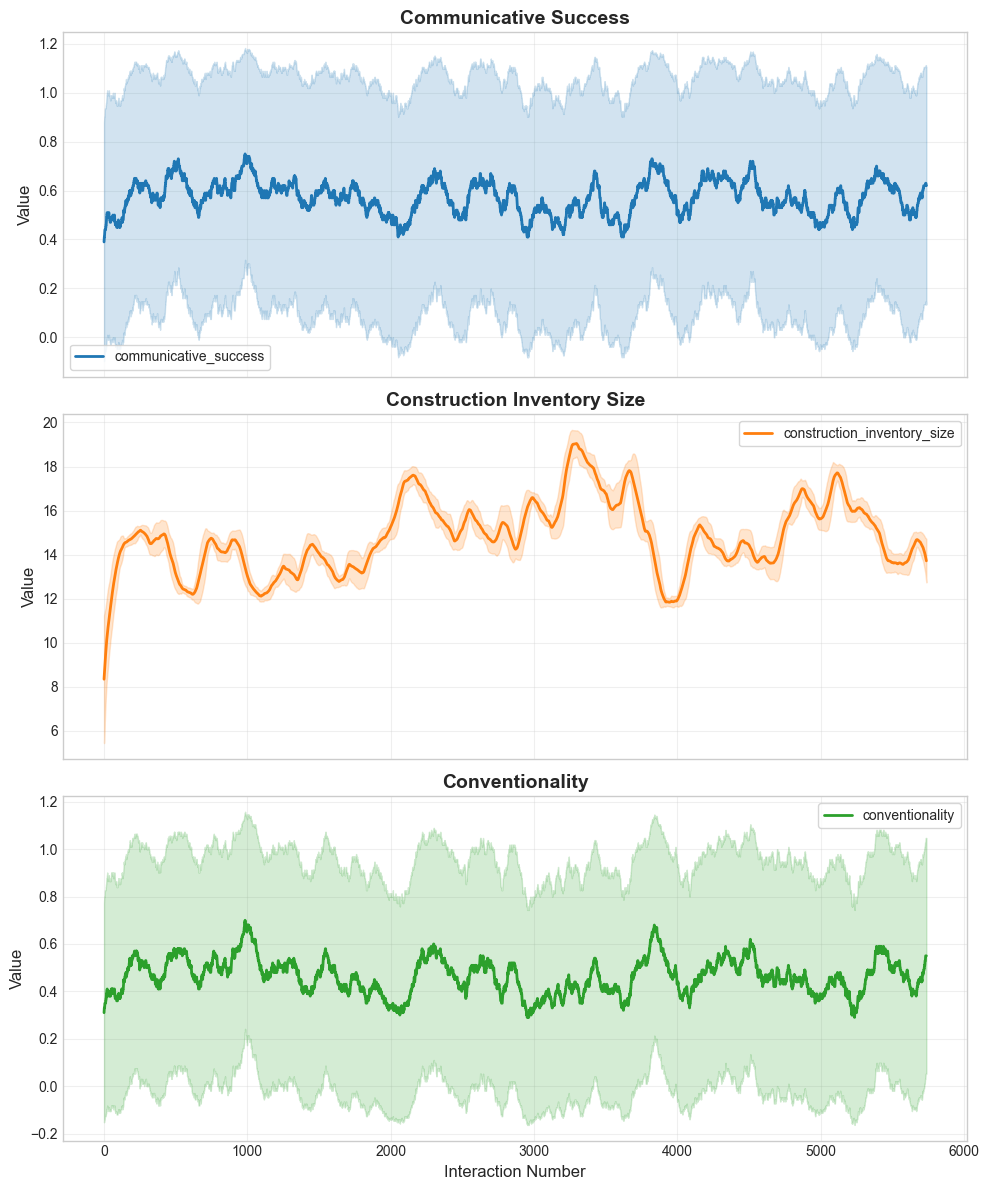

In [ ]:


# Apply smoothing window
window_size = 100

def smooth_and_ci(values, window):
    """Return smoothed mean, lower CI, upper CI."""
    vals = np.array(values)

    # Moving average
    mean = np.convolve(vals, np.ones(window)/window, mode='valid')

    # Moving std
    std = []
    for i in range(len(vals) - window + 1):
        std.append(np.std(vals[i:i+window]))
    std = np.array(std)

    ci_lower = mean - std
    ci_upper = mean + std

    return mean, ci_lower, ci_upper


# Custom colors
colors = {
    "communicative_success": "#1f77b4",   # blue
    "construction_inventory_size": "#ff7f0e",  # orange
    "conventionality": "#2ca02c",   # green
}

plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(len(MONITORS.keys()), figsize=(10, 12), sharex=True)

for i, key in enumerate(MONITORS.keys()):
    ax = axes[i]

    # smooth
    mean, lower, upper = smooth_and_ci(MONITORS[key], window_size)

    # Plot line
    ax.plot(mean, color=colors.get(key, "black"), linewidth=2, label=key)

    # Confidence interval shading
    ax.fill_between(
        range(len(mean)),
        lower,
        upper,
        color=colors.get(key, "black"),
        alpha=0.2,
    )

    ax.set_title(key.replace("_", " ").title(), fontsize=14, weight="bold")
    ax.set_ylabel("Value", fontsize=12)
    ax.legend(frameon=True)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Interaction Number", fontsize=12)

plt.tight_layout()
plt.show()


In [23]:
import pyfcg as fcg

fcg.init()
fcg.start_web_interface(port=8010)

fcg.add_element_to_web_interface("<h1>TEST: L'interfaccia funziona?</h1>")

